# Integrate ClearML

In [1]:
from clearml import Task

In [2]:
task = Task.init(project_name="PCOS Diagnosis", task_name= "CNN")

ClearML Task: created new task id=9cd6baf8c86443009e8d4ae7b9ad16e8
ClearML results page: https://app.clear.ml/projects/f5e21c80429b490ea4443d4f94353224/experiments/9cd6baf8c86443009e8d4ae7b9ad16e8/output/log
ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring


In [3]:
logger = task.get_logger()

# Importing Necessary Modules

In [4]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
plt.rcParams['figure.figsize'] = (12, 8)
import seaborn as sns
sns.set(style='whitegrid', color_codes=True)
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import chi2,f_classif, mutual_info_classif, SelectKBest
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import CVScores
from sklearn.metrics import confusion_matrix

# Load Dataset

In [5]:
df = pd.read_csv('../../datasets/PCOS_clean_data_without_infertility.csv')
df.head(12)

,PCOS (Y/N),Age (yrs),Weight (Kg),Height(Cm),BMI,Blood Group,Pulse rate(bpm),RR (breaths/min),Hb(g/dl),Cycle(R/I),...,Pimples(Y/N),Fast food (Y/N),Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm)
0,0,28,44.6,152.0,19.30,15,78,22,10.48,0,...,0,1.0,0,110,80,3,3,18.0,18.0,8.5
1,0,36,65.0,161.5,24.92,15,74,20,11.70,0,...,0,0.0,0,120,70,3,5,15.0,14.0,3.7
2,1,33,68.8,165.0,25.27,11,72,18,11.80,0,...,1,1.0,0,120,80,13,15,18.0,20.0,10.0
3,0,37,65.0,148.0,29.67,13,72,20,12.00,0,...,0,0.0,0,120,70,2,2,15.0,14.0,7.5
4,0,25,52.0,161.0,20.06,11,72,18,10.00,0,...,0,0.0,0,120,80,3,4,16.0,14.0,7.0
5,0,36,74.1,165.0,27.22,15,78,28,11.20,0,...,0,0.0,0,110,70,9,6,16.0,20.0,8.0
6,0,34,64.0,156.0,26.30,11,72,18,10.90,0,...,0,0.0,0,120,80,6,6,15.0,16.0,6.8
7,0,33,58.5,159.0,23.14,13,72,20,11.00,0,...,0,0.0,0,120,80,7,6,15.0,18.0,7.1
8,0,32,40.0,158.0,16.02,11,72,18,11.80,0,...,0,0.0,0,120,80,5,7,17.0,17.0,4.2
9,0,36,52.0,150.0,23.11,15,80,20,10.00,1,...,0,0.0,0,110,80,1,1,14.0,17.0,2.5


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 538 entries, 0 to 537
Data columns (total 42 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PCOS (Y/N)              538 non-null    int64  
 1   Age (yrs)               538 non-null    int64  
 2   Weight (Kg)             538 non-null    float64
 3   Height(Cm)              538 non-null    float64
 4   BMI                     538 non-null    float64
 5   Blood Group             538 non-null    int64  
 6   Pulse rate(bpm)         538 non-null    int64  
 7   RR (breaths/min)        538 non-null    int64  
 8   Hb(g/dl)                538 non-null    float64
 9   Cycle(R/I)              538 non-null    int64  
 10  Cycle length(days)      538 non-null    int64  
 11  Marraige Status (Yrs)   538 non-null    float64
 12  Pregnant(Y/N)           538 non-null    int64  
 13  No. of aborptions       538 non-null    int64  
 14  I   beta-HCG(mIU/mL)    538 non-null    fl

In [8]:
logger.report_table("PCOS Cleaned Dataset", "Original", iteration=0, table_plot=df)

In [9]:
X = df.drop(["PCOS (Y/N)",
            "Blood Group",
            "Height(Cm)",
            "Pregnant(Y/N)",
             "PRG(ng/mL)",
            "RR (breaths/min)",
            "No. of aborptions",
            "FSH/LH",
            "I   beta-HCG(mIU/mL)",
            "II    beta-HCG(mIU/mL)",
            "TSH (mIU/L)",
            "FSH(mIU/mL)",
            "LH(mIU/mL)",
            "Waist:Hip Ratio",
            "PRL(ng/mL)",
            "BP _Diastolic (mmHg)",
            "BP _Systolic (mmHg)",
            "Reg.Exercise(Y/N)",
            "RBS(mg/dl)"
            ],axis=1)

In [10]:
y = df[["PCOS (Y/N)"]]

# Data Augmentation

## Resampling on Complete Dataset

In [11]:
from imblearn.combine import SMOTEENN

resample = SMOTEENN(sampling_strategy="auto", random_state =0)
X, y = resample.fit_resample(X, y)

In [12]:
logger.report_table("PCOS Cleaned Dataset - X", "Over-Under Sampled", iteration=0, table_plot=X)

In [13]:
logger.report_table("PCOS Cleaned Dataset - y", "Over-Under Sampled", iteration=0, table_plot=y)

## Splitting

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify= y)

In [15]:
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.15, random_state=0, stratify= y_train)

In [16]:
X_train.shape

(325, 23)

In [17]:
X_test.shape

(96, 23)

In [18]:
X_dev.shape

(58, 23)

## Scaling

In [19]:
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler

scaler = MinMaxScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_train = pd.DataFrame(X_train)

X_dev = scaler.transform(X_dev)
X_dev = pd.DataFrame(X_dev)

X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test)


# Setting Column Names from dataset
X_train.columns = X.columns
X_test.columns = X.columns
X_dev.columns = X.columns

# CNN

In [20]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

2022-04-13 16:35:47.752914: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/fsl/5.0
2022-04-13 16:35:47.752952: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [21]:
X_train = X_train.to_numpy().reshape(X_train.shape[0], X_train.shape[1], 1)

In [22]:
# y_train = y_train.to_numpy().reshape(y_train.shape[0], 1)

In [23]:
X_test = X_test.to_numpy().reshape(X_test.shape[0], X_test.shape[1], 1)

In [24]:
# y_test = y_test.to_numpy().reshape(y_test.shape[0], 1)

In [25]:
X_dev = X_dev.to_numpy().reshape(X_dev.shape[0], X_dev.shape[1], 1)

In [26]:
# y_dev = y_dev.to_numpy().reshape(y_dev.shape[0], 1)

In [27]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)
y_dev = to_categorical(y_dev, 2)

### Hyperparameters Define

In [28]:
parameters = {
    'optimizer': "Adam",
    'epochs': 200,
    'early_stopping_paitence':50,
    'loss': 'binary_crossentropy',
    'metric': ['AUC','accuracy', 'Precision', 'Recall']
}

In [29]:
# Report to ClearML
parameters = task.connect(parameters, name="Hyperparameters")

### Build Model

In [30]:
model = models.Sequential()
model.add(layers.Conv1D(128, (3), activation='relu', input_shape=X_train.shape[1:]))
model.add(layers.Conv1D(64, (3), activation='relu'))
model.add(layers.Conv1D(32, (3), activation='relu'))
model.add(layers.Conv1D(64, (3), activation='relu'))
model.add(layers.Conv1D(64, (5), activation='relu'))
model.add(layers.Conv1D(32, (5), activation='relu'))

2022-04-13 16:37:02.902777: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/fsl/5.0
2022-04-13 16:37:02.902815: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-13 16:37:02.902840: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (thinkpad): /proc/driver/nvidia/version does not exist
2022-04-13 16:37:02.904327: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [31]:
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(2, activation='sigmoid'))

In [32]:
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=parameters['early_stopping_paitence'], monitor='val_loss', mode='min'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

In [33]:
model.compile(optimizer=parameters['optimizer'],
              loss=parameters['loss'],
              metrics=parameters['metric'])

In [34]:
model.build(X_train.shape[1:])

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 21, 128)           512       
                                                                 
 conv1d_1 (Conv1D)           (None, 19, 64)            24640     
                                                                 
 conv1d_2 (Conv1D)           (None, 17, 32)            6176      
                                                                 
 conv1d_3 (Conv1D)           (None, 15, 64)            6208      
                                                                 
 conv1d_4 (Conv1D)           (None, 11, 64)            20544     
                                                                 
 conv1d_5 (Conv1D)           (None, 7, 32)             10272     
                                                                 
 flatten (Flatten)           (None, 224)               0

In [36]:
history = model.fit(X_train,y_train,
callbacks=callbacks,
epochs=parameters['epochs'],
validation_data= (X_dev,y_dev))

Epoch 1/200
11/11 [==============================] - 6s 177ms/step - loss: 0.6812 - auc: 0.5899 - accuracy: 0.5508 - precision: 0.5473 - recall: 0.5692 - val_loss: 0.6514 - val_auc: 0.7273 - val_accuracy: 0.5690 - val_precision: 0.5690 - val_recall: 0.5690
Epoch 2/200
11/11 [==============================] - 1s 48ms/step - loss: 0.6490 - auc: 0.6633 - accuracy: 0.5631 - precision: 0.5671 - recall: 0.5723 - val_loss: 0.6101 - val_auc: 0.7365 - val_accuracy: 0.5690 - val_precision: 0.5690 - val_recall: 0.5690
Epoch 3/200
11/11 [==============================] - 0s 41ms/step - loss: 0.6094 - auc: 0.7134 - accuracy: 0.6431 - precision: 0.6110 - recall: 0.7200 - val_loss: 0.5596 - val_auc: 0.7857 - val_accuracy: 0.7414 - val_precision: 0.6471 - val_recall: 0.7586
Epoch 4/200
11/11 [==============================] - 1s 50ms/step - loss: 0.5864 - auc: 0.7528 - accuracy: 0.7262 - precision: 0.6712 - recall: 0.7600 - val_loss: 0.5853 - val_auc: 0.8809 - val_accuracy: 0.8276 - val_precision: 0.7

### Evaluate Model

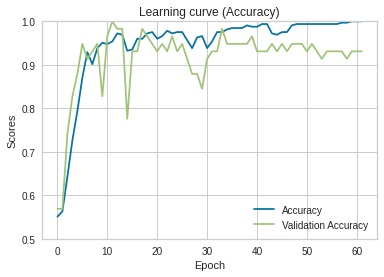

In [37]:
plt.figure(figsize=(6, 4))
plt.title("Learning curve (Accuracy)")
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Scores')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show() # Necessary to track plot with ClearML

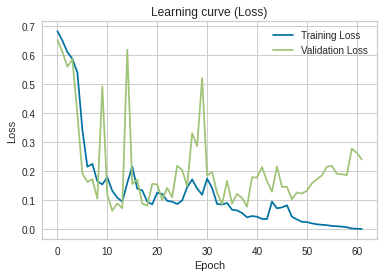

In [38]:
plt.figure(figsize=(6, 4))
plt.title("Learning curve (Loss)")
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show() # Necessary to track plot with ClearML

In [39]:
model.evaluate(X_test,  y_test, verbose=1)

3/3 [==============================] - 1s 14ms/step - loss: 0.5815 - auc: 0.9403 - accuracy: 0.9271 - precision: 0.9263 - recall: 0.9167


[0.5814575552940369,
 0.9403212666511536,
 0.9270833134651184,
 0.9263157844543457,
 0.9166666865348816]

# Close ClearML Task

In [127]:
task.close()